In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(224),  # 将 CIFAR-10 图像调整为 224x224，适配 ResNet-18
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 使用 ImageNet 的均值和标准差
])

In [ ]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

C:\Users\12902\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\12902\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 10
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

torch.save(model.state_dict(), "initial_resnet18.pth")

Epoch [1/10], Train Loss: 0.6028, Train Accuracy: 79.44%, Val Loss: 0.4780, Val Accuracy: 83.85%
Epoch [2/10], Train Loss: 0.3729, Train Accuracy: 87.14%, Val Loss: 0.4579, Val Accuracy: 84.69%
Epoch [3/10], Train Loss: 0.2852, Train Accuracy: 90.28%, Val Loss: 0.4115, Val Accuracy: 86.70%
Epoch [4/10], Train Loss: 0.2399, Train Accuracy: 91.77%, Val Loss: 0.3907, Val Accuracy: 87.21%
Epoch [5/10], Train Loss: 0.2088, Train Accuracy: 92.71%, Val Loss: 0.4300, Val Accuracy: 86.27%
Epoch [6/10], Train Loss: 0.1770, Train Accuracy: 94.00%, Val Loss: 0.4605, Val Accuracy: 85.76%
Epoch [7/10], Train Loss: 0.1545, Train Accuracy: 94.62%, Val Loss: 0.4947, Val Accuracy: 84.11%
Epoch [8/10], Train Loss: 0.1394, Train Accuracy: 95.28%, Val Loss: 0.3918, Val Accuracy: 88.22%
Epoch [9/10], Train Loss: 0.1299, Train Accuracy: 95.48%, Val Loss: 0.4154, Val Accuracy: 86.91%
Epoch [10/10], Train Loss: 0.1122, Train Accuracy: 96.26%, Val Loss: 0.4604, Val Accuracy: 86.61%


In [ ]:
learning_rates = [0.001, 0.0001]
weight_decays = [0.0001, 0.001]
best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for wd in weight_decays:
        print(f"Evaluating with learning rate={lr}, weight_decay={wd}")

        model.load_state_dict(torch.load("initial_resnet18.pth"))
        model.eval()

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'learning_rate': lr, 'weight_decay': wd}

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

Evaluating with learning rate=0.001, weight_decay=0.0001


C:\Users\12902\AppData\Local\Temp\ipykernel_29740\2787441797.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("initial_resnet18.pth"))


Validation Accuracy: 86.61%
Evaluating with learning rate=0.001, weight_decay=0.001
Validation Accuracy: 86.61%
Evaluating with learning rate=0.0001, weight_decay=0.0001
Validation Accuracy: 86.61%
Evaluating with learning rate=0.0001, weight_decay=0.001
Validation Accuracy: 86.61%
Best Parameters: {'learning_rate': 0.001, 'weight_decay': 0.0001}
Best Validation Accuracy: 86.61%


In [ ]:
model.load_state_dict(torch.load("initial_resnet18.pth"))
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

retrain_accuracies, retrain_losses = [], []
retrain_val_accuracies, retrain_val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    retrain_losses.append(running_loss / len(train_loader))
    retrain_accuracies.append(100 * correct / total)

    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    retrain_val_losses.append(val_running_loss / len(val_loader))
    retrain_val_accuracies.append(100 * val_correct / val_total)
    print(f'Re-trained Epoch [{epoch+1}/{num_epochs}], Loss: {retrain_losses[-1]:.4f}, Acc: {retrain_accuracies[-1]:.2f}%, Val Loss: {retrain_val_losses[-1]:.4f}, Val Acc: {retrain_val_accuracies[-1]:.2f}%')


C:\Users\12902\AppData\Local\Temp\ipykernel_29740\3119305908.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("initial_resnet18.pth"))


Re-trained Epoch [1/10], Loss: 0.1177, Acc: 96.00%, Val Loss: 0.4117, Val Acc: 87.84%
Re-trained Epoch [2/10], Loss: 0.1024, Acc: 96.57%, Val Loss: 0.3597, Val Acc: 89.09%
Re-trained Epoch [3/10], Loss: 0.0953, Acc: 96.74%, Val Loss: 0.4317, Val Acc: 87.32%
Re-trained Epoch [4/10], Loss: 0.0909, Acc: 96.92%, Val Loss: 0.4710, Val Acc: 86.38%
Re-trained Epoch [5/10], Loss: 0.0839, Acc: 97.12%, Val Loss: 0.4459, Val Acc: 87.71%
Re-trained Epoch [6/10], Loss: 0.0860, Acc: 97.06%, Val Loss: 0.4032, Val Acc: 88.49%
Re-trained Epoch [7/10], Loss: 0.0797, Acc: 97.34%, Val Loss: 0.4420, Val Acc: 87.22%
Re-trained Epoch [8/10], Loss: 0.0782, Acc: 97.33%, Val Loss: 0.3852, Val Acc: 89.04%
Re-trained Epoch [9/10], Loss: 0.0742, Acc: 97.44%, Val Loss: 0.4768, Val Acc: 86.86%
Re-trained Epoch [10/10], Loss: 0.0746, Acc: 97.48%, Val Loss: 0.4740, Val Acc: 87.27%


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy with Best Parameters: {test_accuracy:.2f}%")

Test Accuracy with Best Parameters: 87.32%


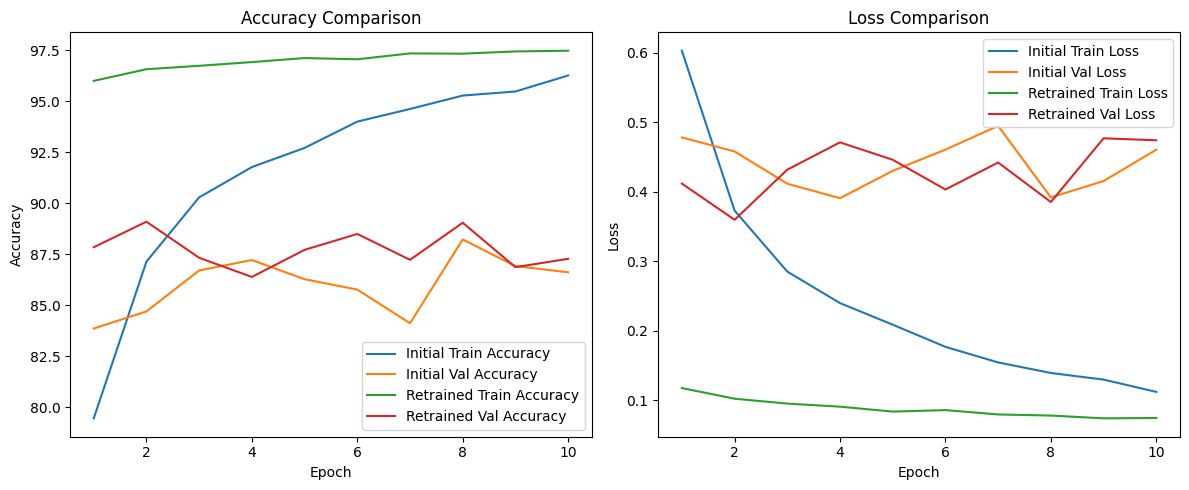

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Initial Train Accuracy')
plt.plot(epochs, val_accuracies, label='Initial Val Accuracy')
plt.plot(epochs, retrain_accuracies, label='Retrained Train Accuracy')
plt.plot(epochs, retrain_val_accuracies, label='Retrained Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Initial Train Loss')
plt.plot(epochs, val_losses, label='Initial Val Loss')
plt.plot(epochs, retrain_losses, label='Retrained Train Loss')
plt.plot(epochs, retrain_val_losses, label='Retrained Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

plt.tight_layout()
plt.show()